In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sdebridge import diffusion_bridge as db
from sdebridge import sdes
from sdebridge.utils import score_fn, fourier_coefficients, inverse_fourier
from sdebridge.data_processing import sample_ellipse

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
N=50
dim=2
num_bases = 2
alpha = 1.0
sigma = 1.0
n_grid = 5
grid_range = (-1.5, 1.5)
n_samples = 100

sde = sdes.fourier_gaussian_kernel_sde(T, N, dim, num_bases, alpha, sigma, n_grid, grid_range, n_samples)

In [4]:
initial_butterfly = jnp.load('../data/tom_pts.npy')
target_butterfly = jnp.load('../data/honrathi_pts.npy')

initial_coeffs = fourier_coefficients(initial_butterfly, num_bases)
target_coeffs = fourier_coefficients(target_butterfly, num_bases)


ellipse_pts_target = sample_ellipse(n_samples, scale=0.5)
ellipse_target = fourier_coefficients(ellipse_pts_target, num_bases)

ellipse_pts_init = sample_ellipse(n_samples, scale=0.7)
ellipse_init = fourier_coefficients(ellipse_pts_init, num_bases)

In [9]:
print(initial_coeffs.shape)

(2, 2, 2)


In [5]:
# def plot_butterfly_pts(pts, ax, color='r', label=None):
#     ax.scatter(pts[:, 0], pts[:, 1], color=color, label=label, s=10)
#     ax.plot(pts[:, 0], pts[:, 1], color=color, alpha=0.5, linestyle='--')
#     return ax
# 
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax = plot_butterfly_pts(initial_butterfly, ax, color='r', label='initial')
# ax = plot_butterfly_pts(target_butterfly, ax, color='b', label='target')
# ax.legend()
# plt.show()

In [6]:
# # plot butterflies reconstructed from coeffs
# 
# initial_plt = inverse_fourier(initial_coeffs, 120)
# target_plt = inverse_fourier(target_coeffs, 120)
# 
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax = plot_butterfly_pts(initial_plt, ax, color='r', label='initial')
# ax = plot_butterfly_pts(target_plt, ax, color='b', label='target')
# ax.legend()
# plt.show()

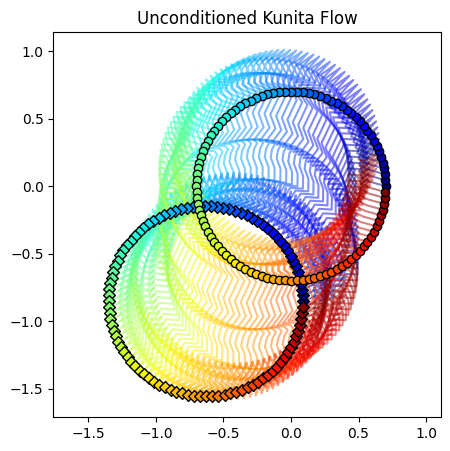

In [7]:
from sdebridge.plotting import plot_single_trajectory

key = jax.random.PRNGKey(2)
forward_trajs = sdes.simulate_traj(sde, ellipse_init, 64, key)
forward_traj_coeffs = forward_trajs[1]
forward_traj = inverse_fourier(forward_traj_coeffs, 100)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Kunita Flow")

In [8]:
from sdebridge.networks.score_unet import ScoreUNet

net = ScoreUNet

network = {
    "output_dim": sde.dim*sde.n_bases,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [32, 16, 8],
    "decoder_layer_dims": [8, 16, 32],
    "batchnorm": True,
}
    
training = {
    "batch_size": 64,
    "load_size": 100*64,
    "num_epochs": 100,
    "learning_rate": 1e-2,
    "warmup_steps": 0,
}

target = ellipse_target

train_key = jax.random.split(key, 2)[0]
score_p_state = db.learn_p_score(sde, target, train_key, **training, net=net, network_params=network)

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]2024-05-16 13:54:59.072596: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: IndexError: Too many indices for array: 3 non-None/Ellipsis indices for dim 2.
Traceback (most recent call last):

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/libbybaker/Documents/Python/sdebridge-project/sdebridge/sdebridge/diffusion_bridge.py", line 31, in generator
    trajs, grads, covs

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} IndexError: Too many indices for array: 3 non-None/Ellipsis indices for dim 2.
Traceback (most recent call last):

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/libbybaker/Documents/Python/sdebridge-project/sdebridge/sdebridge/diffusion_bridge.py", line 31, in generator
    trajs, grads, covs = euler_and_grad_and_cov(sde, initial_vals, key)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/sdebridge/sdebridge/diffusion_bridge.py", line 265, in euler_and_grad_and_cov
    _, (trajectories, gradients, covariances, step_keys) = jax.lax.scan(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/lax/control_flow/loops.py", line 258, in scan
    init_flat, carry_avals, carry_avals_out, init_tree, *rest = _create_jaxpr(init)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/lax/control_flow/loops.py", line 244, in _create_jaxpr
    jaxpr, consts, out_tree = _initial_style_jaxpr(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/lax/control_flow/common.py", line 67, in _initial_style_jaxpr
    jaxpr, consts, out_tree = _initial_style_open_jaxpr(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/lax/control_flow/common.py", line 61, in _initial_style_open_jaxpr
    jaxpr, _, consts = pe.trace_to_jaxpr_dynamic(wrapped_fun, in_avals, debug)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/profiler.py", line 336, in wrapper
    return func(*args, **kwargs)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/interpreters/partial_eval.py", line 2288, in trace_to_jaxpr_dynamic
    jaxpr, out_avals, consts = trace_to_subjaxpr_dynamic(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/interpreters/partial_eval.py", line 2310, in trace_to_subjaxpr_dynamic
    ans = fun.call_wrapped(*in_tracers_)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/linear_util.py", line 191, in call_wrapped
    ans = self.f(*args, **dict(self.params, **kwargs))

  File "/Users/libbybaker/Documents/Python/sdebridge-project/sdebridge/sdebridge/diffusion_bridge.py", line 243, in euler_maruyama_step
    diffusion_ = jax.vmap(sde.diffusion, in_axes=(0, None))(s.x, time)  # (B, 2*n_bases, 2*n_grid**2)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/api.py", line 1258, in vmap_f
    out_flat = batching.batch(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/linear_util.py", line 191, in call_wrapped
    ans = self.f(*args, **dict(self.params, **kwargs))

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/pjit.py", line 257, in cache_miss
    outs, out_flat, out_tree, args_flat, jaxpr = _python_pjit_helper(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/pjit.py", line 163, in _python_pjit_helper
    args_flat, _, params, in_tree, out_tree, _, _, _ = infer_params_fn(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/api.py", line 317, in infer_params
    return pjit.common_infer_params(pjit_info_args, *args, **kwargs)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/pjit.py", line 493, in common_infer_params
    jaxpr, consts, canonicalized_out_shardings_flat, out_layouts_flat = _pjit_jaxpr(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/pjit.py", line 996, in _pjit_jaxpr
    jaxpr, final_consts, out_type = _create_pjit_jaxpr(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/linear_util.py", line 349, in memoized_fun
    ans = call(fun, *args)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/pjit.py", line 936, in _create_pjit_jaxpr
    jaxpr, global_out_avals, consts = pe.trace_to_jaxpr_dynamic(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/profiler.py", line 336, in wrapper
    return func(*args, **kwargs)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/interpreters/partial_eval.py", line 2288, in trace_to_jaxpr_dynamic
    jaxpr, out_avals, consts = trace_to_subjaxpr_dynamic(

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/interpreters/partial_eval.py", line 2310, in trace_to_subjaxpr_dynamic
    ans = fun.call_wrapped(*in_tracers_)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/linear_util.py", line 191, in call_wrapped
    ans = self.f(*args, **dict(self.params, **kwargs))

  File "/Users/libbybaker/Documents/Python/sdebridge-project/sdebridge/sdebridge/sdes.py", line 306, in diffusion
    Q_eval = evaluate_Q(val)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/sdebridge/sdebridge/sdes.py", line 297, in evaluate_Q
    X_pts = inverse_fourier(X_coeffs, n_samples)  # (n_bases, 2)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/sdebridge/sdebridge/sdes.py", line 289, in inverse_fourier
    coeffs_real = coefficients[..., 0, :, :]

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py", line 743, in op
    return getattr(self.aval, f"_{name}")(self, *args)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py", line 356, in _getitem
    return lax_numpy._rewriting_take(self, item)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py", line 4494, in _rewriting_take
    return _gather(arr, treedef, static_idx, dynamic_idx, indices_are_sorted,

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py", line 4503, in _gather
    indexer = _index_to_gather(shape(arr), idx)  # shared with _scatter_update

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py", line 4604, in _index_to_gather
    idx = _canonicalize_tuple_index(len(x_shape), idx)

  File "/Users/libbybaker/Documents/Python/sdebridge-project/env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py", line 4913, in _canonicalize_tuple_index
    raise IndexError(

IndexError: Too many indices for array: 3 non-None/Ellipsis indices for dim 2.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
reverse_sde = sdes.reverse(sde, score_fn(score_p_state))
backward_coeffs = sdes.simulate_traj(reverse_sde, ellipse_init, 2, key)
forward_coeffs = sdes.simulate_traj(sde, ellipse_init, 2, key)

In [ ]:
backward_traj = inverse_fourier(backward_coeffs[0], 100)
traj = backward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Conditioned Brownian Motion")
target_plt = inverse_fourier(target, 50)
plt.scatter(target_plt[:, 0], target_plt[:, 1], c="b")

ellipse = sample_ellipse(n_samples, shifts=jnp.array([0.2, 0]), scale=0.5)
plt.scatter(ellipse[:, 0], ellipse[:, 1], c="g")


forward_traj = inverse_fourier(forward_coeffs[0], 100)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")

In [ ]:
plt_backward_coeffs = backward_coeffs[0]
print(backward_coeffs.shape)

for i in [0, 1, 2, 3]:
    plt.scatter(plt_backward_coeffs[-1, i, 0], plt_backward_coeffs[-1, i, 1], color=f"C{i}")
    plt.scatter(plt_backward_coeffs[0, i, 0], plt_backward_coeffs[0, i, 1], color=f"C{i}", marker="P")

    # plt.plot(plt_backward_coeffs[:, coeff, 0], plt_backward_coeffs[:, coeff, 1], color=f"C{i}")
    plt.scatter(target[i, 0], target[i, 1], color=f"C{i}", marker="X")